# Project 2: Credit Risk and Statistical Learning

**Names of all group members:**
- Matthias Wyss (matthias.wyss@epfl.ch)
- William Jallot (william.jallot@epfl.ch)
- Antoine Garin (antoine.garin@epfl.ch)


---

All code below is only suggestive and you may as well use different approaches.

## Exercise 1 - Feature Generation

In [1]:
# Exercise 1.
import numpy as np

np.random.seed(0)  # for reproducibility

# simulate explanatory variables x
m, n = 20000, 10000  # training and test sizes
total = m + n

# x1: age (18-80)
x1 = np.random.uniform(18, 80, size=total)

# x2: monthly income in kCHF (1-15)
x2 = np.random.uniform(1, 15, size=total)

# x3: employment status (0 = salaried, 1 = self-employed)
x3 = np.random.choice([0, 1], size=total, p=[0.9, 0.1])

# stack into a feature matrix
X = np.column_stack((x1, x2, x3))

# a) calculate empirical means and standard deviations over training data
X_train = X[:m]  # first m samples as training data

means = X_train.mean(axis=0)
stds = X_train.std(axis=0, ddof=1)  # use ddof=1 for sample std

print("Empirical means (training data):", means)
print("Empirical stds  (training data):", stds)


# b) Suggest other variables that would realistically be relevant in credit scoring.
# (you do not have to implement those of course, just explain your answer in writing)
"""
Other variables that could be relevant for credit scoring include:
- Credit history: past defaults, number of open loans, payment history.
- Debt-to-income ratio: proportion of income already committed to debt payments.
- Employment stability: length of current job, number of job changes.
- Marital status / dependents: may affect financial obligations.
- Education level: can correlate with income stability.
- Age brackets or life stage: young vs. near retirement may carry different risk.
- Housing situation: renter, owner, mortgage payments.
- Other financial indicators: savings, assets, or investments.
These features help better capture the borrower's ability and likelihood to repay.
"""

Empirical means (training data): [48.7426539   7.98652219  0.1017    ]
Empirical stds  (training data): [18.00788849  4.03090363  0.30226094]


"\nOther variables that could be relevant for credit scoring include:\n- Credit history: past defaults, number of open loans, payment history.\n- Debt-to-income ratio: proportion of income already committed to debt payments.\n- Employment stability: length of current job, number of job changes.\n- Marital status / dependents: may affect financial obligations.\n- Education level: can correlate with income stability.\n- Age brackets or life stage: young vs. near retirement may carry different risk.\n- Housing situation: renter, owner, mortgage payments.\n- Other financial indicators: savings, assets, or investments.\nThese features help better capture the borrower's ability and likelihood to repay.\n"

## Exercise 2 - Default Model and Data Generation

In [2]:
# Exercise 2.
# Building the datasets:

sigmoid = lambda x: 1. / (1. + np.exp(-x))

# generate uniform random variables for thresholds
xi = np.random.uniform(0, 1, size=total)

# --- build the first dataset ---
# repayment probability function p1
p1 = lambda x1, x2, x3: sigmoid(13.3 - 0.33*x1 + 3.5*x2 - 3*x3)

# labels: 1 = repayment, 0 = default
y1 = lambda xi, x1, x2, x3: (xi <= p1(x1, x2, x3)).astype(int)

# --- build the second dataset ---
# repayment probability function p2
p2 = lambda x1, x2, x3: sigmoid(5 - 10*((x1 < 25) | (x1 > 75)) + 1.1*x2 - x3)

y2 = lambda xi, x1, x2, x3: (xi <= p2(x1, x2, x3)).astype(int)

In [3]:
# Exercise 2. a)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# "model = LogisticRegression().fit(X_data, Y_data)" fits a model
# "pred_X = model.predict_proba(X)" evaluates the model
# (note that it outputs both P(Y=0|X) and P(Y=1|X))
# "log_loss(Y, pred_X)" evaluates the negative conditional log likelihood (also called cross-entropy loss)

# Evaluate labels using the lambda functions
y1_vals = y1(xi, x1, x2, x3)
y2_vals = y2(xi, x1, x2, x3)

# Split train and test
X_train, X_test = X[:m], X[m:]
y1_train, y1_test = y1_vals[:m], y1_vals[m:]
y2_train, y2_test = y2_vals[:m], y2_vals[m:]

# --- Logistic Regression for dataset 1 ---
logreg1 = LogisticRegression(max_iter=1000)
logreg1.fit(X_train, y1_train)

pred1_train_logreg = logreg1.predict_proba(X_train)
pred1_test_logreg = logreg1.predict_proba(X_test)

loss1_train_logreg = log_loss(y1_train, pred1_train_logreg)
loss1_test_logreg = log_loss(y1_test, pred1_test_logreg)

print("Dataset 1 - Logistic Regression:")
print("Train cross-entropy loss:", loss1_train_logreg)
print("Test cross-entropy loss: ", loss1_test_logreg)

# --- Logistic Regression for dataset 2 ---
logreg2 = LogisticRegression(max_iter=1000)
logreg2.fit(X_train, y2_train)

pred2_train_logreg = logreg2.predict_proba(X_train)
pred2_test_logreg = logreg2.predict_proba(X_test)

loss2_train_logreg = log_loss(y2_train, pred2_train_logreg)
loss2_test_logreg = log_loss(y2_test, pred2_test_logreg)

print("\nDataset 2 - Logistic Regression:")
print("Train cross-entropy loss:", loss2_train_logreg)
print("Test cross-entropy loss: ", loss2_test_logreg)

Dataset 1 - Logistic Regression:
Train cross-entropy loss: 0.02965714449391653
Test cross-entropy loss:  0.03486030904708876

Dataset 2 - Logistic Regression:
Train cross-entropy loss: 0.15353916049547306
Test cross-entropy loss:  0.14864431254820354


In [4]:
# Exercise 2.b)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

# Calculate normalized data

# "model = SVC(kernel='rbf', gamma=GAMMA, C=C, probability=True)" creates
# a model with kernel exp(-GAMMA \|x-x'\|_2^2) and regul. parameter C (note the relation between C and the parameter lambda).
# "probability=True" enables the option "model.predict_proba(X)" to predict probabilities from the regression function \hat{f}^{svm}.
# "model.fit(X, Y)" optimizes the model parameters (using hinge loss)

# Fit the models for both datasets (this can take up to 60 seconds with SVC)

# "model.predict_proba(X)" predicts probabilities from features (note that it outputs both P(Y=0|X) and P(Y=1|X))

# Calculate cross-entropy loss on both datasets for train and test



# --- Standardize features using training set statistics ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# regularization parameter for SVM
C = 0.2
GAMMA = 1/10

# --- SVM for dataset 1 ---
svm1 = SVC(kernel='rbf', C=C, gamma=GAMMA, probability=True)
svm1.fit(X_train_scaled, y1_train)

pred1_train_svm = svm1.predict_proba(X_train_scaled)
pred1_test_svm  = svm1.predict_proba(X_test_scaled)

loss1_train_svm = log_loss(y1_train, pred1_train_svm)
loss1_test_svm  = log_loss(y1_test, pred1_test_svm)

print("Dataset 1 - SVM (RBF kernel):")
print("Train cross-entropy loss:", loss1_train_svm)
print("Test cross-entropy loss: ", loss1_test_svm)

# --- SVM for dataset 2 ---
svm2 = SVC(kernel='rbf', C=C, gamma=GAMMA, probability=True)
svm2.fit(X_train_scaled, y2_train)

pred2_train_svm = svm2.predict_proba(X_train_scaled)
pred2_test_svm  = svm2.predict_proba(X_test_scaled)

loss2_train_svm = log_loss(y2_train, pred2_train_svm)
loss2_test_svm  = log_loss(y2_test, pred2_test_svm)

print("\nDataset 2 - SVM (RBF kernel):")
print("Train cross-entropy loss:", loss2_train_svm)
print("Test cross-entropy loss: ", loss2_test_svm)

Dataset 1 - SVM (RBF kernel):
Train cross-entropy loss: 0.03190726171904052
Test cross-entropy loss:  0.03877479994813939

Dataset 2 - SVM (RBF kernel):
Train cross-entropy loss: 0.07108349621546192
Test cross-entropy loss:  0.06706802419516782


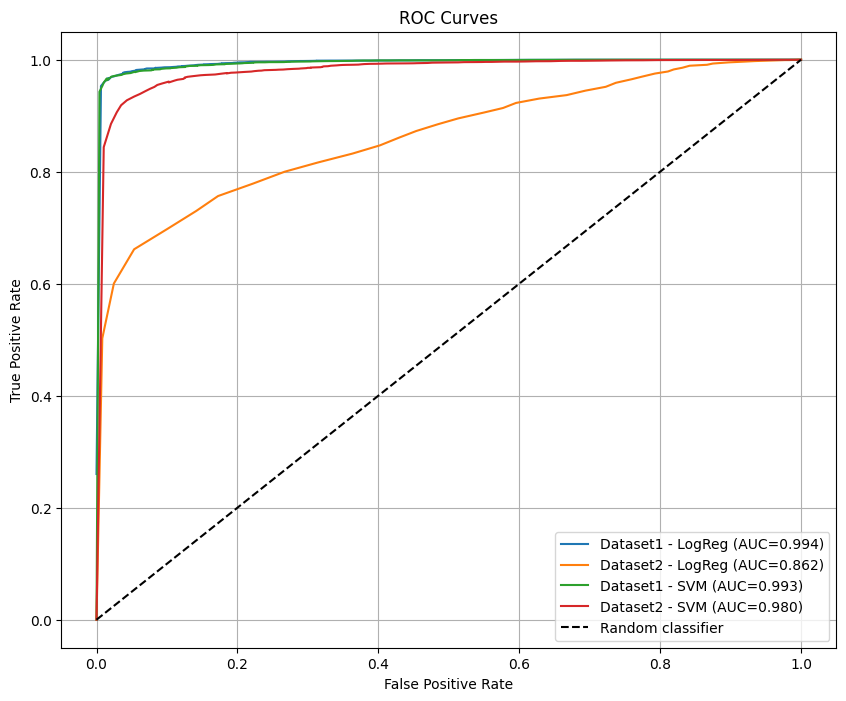

In [5]:
# Exercise 2.c)
import matplotlib.pyplot as plt
# To calculate the curves, it is fine to take 100 threshold values c, i.e.,
ths = np.linspace(0, 1, 100)

# To approximately calculate the AUC, it is fine to simply use Riemann sums.
# This means, if you have 100 (a_i, b_i) pairs for the curves, a_1 <= a_2 <= ...
# then you may simply use the sum
# sum_{i=1}^99 (b_i + b_{i+1})/2 * (a_{i+1}-a_i)
# as the approximation of the integral (or AUC)


# first data set & logistic regression:
# (the code should be reusable for all cases, only exchanging datasets and predicted probabilities depending on the model)

# Compute and plot the ROC and AUC cruves


# second data set & logistic regression:


# first data set and SVM:


# second data set and SVM:

def compute_roc_auc(y_true, y_pred_probs, n_thresholds=100):
    """
    Compute ROC curve points (FPR, TPR) and approximate AUC using Riemann sum.
    
    Parameters:
        y_true: array of true binary labels (0 or 1)
        y_pred_probs: array of predicted probabilities for Y=1
        n_thresholds: number of thresholds to evaluate
    
    Returns:
        fpr: array of false positive rates
        tpr: array of true positive rates
        auc: approximate AUC
    """
    thresholds = np.linspace(0, 1, n_thresholds)
    tpr = []
    fpr = []
    
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    
    for c in thresholds:
        y_pred = (y_pred_probs >= c).astype(int)
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        tpr.append(TP / P)
        fpr.append(FP / N)
    
    tpr = np.array(tpr)
    fpr = np.array(fpr)

    # Sort by FPR (ascending)
    sorted_indices = np.argsort(fpr)
    fpr = fpr[sorted_indices]
    tpr = tpr[sorted_indices]
    
    # approximate AUC using Riemann sum
    auc = np.sum((tpr[:-1] + tpr[1:]) / 2 * (fpr[1:] - fpr[:-1]))
    
    return fpr, tpr, auc

# Plot all 4 cases:

plt.figure(figsize=(10, 8))

# Dataset 1 - Logistic Regression
fpr, tpr, auC = compute_roc_auc(y1_test, pred1_test_logreg[:,1])
plt.plot(fpr, tpr, label=f'Dataset1 - LogReg (AUC={auC:.3f})')

# Dataset 2 - Logistic Regression
fpr, tpr, auC = compute_roc_auc(y2_test, pred2_test_logreg[:,1])
plt.plot(fpr, tpr, label=f'Dataset2 - LogReg (AUC={auC:.3f})')

# Dataset 1 - SVM
fpr, tpr, auC = compute_roc_auc(y1_test, pred1_test_svm[:,1])
plt.plot(fpr, tpr, label=f'Dataset1 - SVM (AUC={auC:.3f})')

# Dataset 2 - SVM
fpr, tpr, auC = compute_roc_auc(y2_test, pred2_test_svm[:,1])
plt.plot(fpr, tpr, label=f'Dataset2 - SVM (AUC={auC:.3f})')

plt.plot([0,1],[0,1],'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 3 - Lending Strategies

In [6]:
# Exercise 3.

# Set model parameters and define matrix D


# Scenario 1:
# Define Portfolio and possible outcomes for this portfolio using matrix D


# Plot the histogram of profits and losses


# Calculate expected profit and losses, compute 95%-VaR and 95%-ES


# Scenario 2:
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the logistic regression model


# Plot the histogram of profits and losses


# Calculate expected profit and losses, compute 95%-VaR and 95%-ES


# Scenario 3:
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the SVM model


# Plot the histogram of profits and losses


# Calculate expected profit and losses, compute 95%-VaR and 95%-ES